In [1]:
include("dependencies.jl")
include("functions/brute_force_new.jl")
include("functions/boundary_evolution.jl")
push!(LOAD_PATH, "functions/")
using BP, Ising2D
using Plots
using Colors  # for color conversion

In [2]:
function loop_corrected_free_energy(L,β;h=0,random_part=0.1)
    N = 2 * L^2
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, BPedges, BPlinks;random_part=random_part) 
    messages = BP.message_passing(tensors, messages, BPedges, BPadj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_l = BP.get_fixed_point_list(tensors, messages, BPadj_mat)
    # Use log-sum trick for numerical stability: log(prod(Z_l)) = sum(log.(Z_l))
    log_Z_sum = sum(log.(real.(Z_l)))    
    # free_energy = - log_Z_sum / (2 * L^2)
    T_normalized = BP.normalize_tensors(tensors,Z_l)
    correction_l = []

    Z = 1.
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    Z += ZCorrection4th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    Z += ZCorrection6th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    Z += ZCorrection7th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    return real(correction_l)
end 


function log_loop_corrected_free_energy(L,β;h=0,random_part=0.1)
    N = 2 * L^2
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, BPedges, BPlinks;random_part=random_part) 
    messages = BP.message_passing(tensors, messages, BPedges, BPadj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_l = BP.get_fixed_point_list(tensors, messages, BPadj_mat)
    # Use log-sum trick for numerical stability: log(prod(Z_l)) = sum(log.(Z_l))
    log_Z_sum = sum(log.(real.(Z_l)))    
    # free_energy = - log_Z_sum / (2 * L^2)
    T_normalized = BP.normalize_tensors(tensors,Z_l)

    log_correction_l = []
    logZ = 0.0  # Initialize as Float64 instead of Int
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    
    # Remove scalar() calls since corrections are already scalar values
    correction_4th = real(logZCorrection4th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat))
    logZ += correction_4th
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    
    correction_6th = real(logZCorrection6th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat))
    logZ += correction_6th
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    
    correction_7th = real(logZCorrection7th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat))
    logZ += correction_7th
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    return real(log_correction_l)
end 

log_loop_corrected_free_energy (generic function with 1 method)

Computing free energy for L=16... 100%|██████████████████| Time: 0:01:05


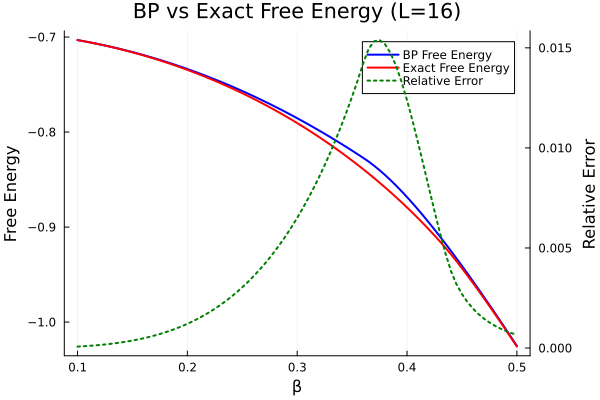

In [3]:
L = 16  # Define L here
β_arr = collect(0.1:0.005:0.5)
h = 0.0  # External magnetic field (assuming zero if not specified)
free_energy_arr = Float64[]
exact_free_energy = Float64[]
 
# Progress meter to track computation
@showprogress "Computing free energy for L=$L..." for β in β_arr
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, BPedges, BPlinks;random_part=.1) 
    messages = BP.message_passing(tensors, messages, BPedges, BPadj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_l = BP.get_fixed_point_list(tensors, messages, BPadj_mat)
    # Use log-sum trick for numerical stability: log(prod(Z_l)) = sum(log.(Z_l))
    log_Z_sum = sum(log.(real.(Z_l)))    
    free_energy = - log_Z_sum / (2 * L^2)
    push!(free_energy_arr, free_energy)
    push!(exact_free_energy, Ising2D.free_energy(β))
end

# Calculate relative error
relative_error = abs.(free_energy_arr .- exact_free_energy) ./ abs.(exact_free_energy)

# Create plot with two y-axes
p1 = plot(β_arr, free_energy_arr, 
          linewidth=2, 
          label="BP Free Energy", 
          color=:blue,
          xlabel="β", 
          ylabel="Free Energy",
          title="BP vs Exact Free Energy (L=$L)",
          legend=:topright)

plot!(p1, β_arr, exact_free_energy, 
      linewidth=2, 
      label="Exact Free Energy", 
      color=:red)

# Create second y-axis for relative error
p2 = twinx(p1)
plot!(p2, β_arr, relative_error, 
      linewidth=2, 
      color=:green, 
      linestyle=:dot,
      label="Relative Error",
      ylabel="Relative Error",
      legend=false)  # Disable legend for second axis

# Manually create combined legend
plot!(p1, [], [], 
      linewidth=2, 
      color=:green, 
      linestyle=:dot,
      label="Relative Error")

# Display the plot
display(p1)

In [ ]:
L = 10  # Define L here
β_arr = collect(0.3:0.0005:0.5)
h = 0.0  # External magnetic field (assuming zero if not specified)
free_energy_arr = Float64[]
exact_free_energy = Float64[]
 
# Progress meter to track computation
@showprogress "Computing free energy for L=$L..." for β in β_arr
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, BPedges, BPlinks;random_part=.1) 
    messages = BP.message_passing(tensors, messages, BPedges, BPadj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_l = BP.get_fixed_point_list(tensors, messages, BPadj_mat)
    # Use log-sum trick for numerical stability: log(prod(Z_l)) = sum(log.(Z_l))
    log_Z_sum = sum(log.(real.(Z_l)))    
    free_energy = - log_Z_sum / (2 * L^2)
    push!(free_energy_arr, free_energy)
    push!(exact_free_energy, Ising2D.free_energy(β))
end

# Calculate relative error
relative_error = abs.(free_energy_arr .- exact_free_energy) ./ abs.(exact_free_energy)



Computing free energy for L=10... 100%|██████████████████| Time: 0:02:38
Computing free energy for L=10... 100%|██████████████████| Time: 0:02:38


401-element Vector{Float64}:
 -3.1864691210081673
 -3.1864691210081673
 -3.191959540682626
 -3.19747574328843
 -3.203015756625399
 -3.2085890935284964
 -3.214181683919287
 -3.219803392795478
 -3.2254532018605113
 -3.2311281783492456
  ⋮
 -3.0756136801812715
 -3.0527582284278707
 -3.0301526967590973
 -3.0077907071657193
 -2.9856688730234224
 -2.963783118481439
 -2.9421296385834186
 -2.9207045084689245
 -2.9207045084689245

In [27]:
# Calculate first derivatives using finite differences (central difference)
function first_derivative(x_vals, y_vals)
    n = length(y_vals)
    dy = zeros(n)
    
    # Use central difference for interior points
    for i in 2:(n-1)
        h = x_vals[i+1] - x_vals[i]  # Assuming uniform spacing
        dy[i] = (y_vals[i+1] - y_vals[i-1]) / (2*h)
    end
    
    # Use forward/backward difference for endpoints
    h = x_vals[2] - x_vals[1]
    dy[1] = (y_vals[2] - y_vals[1]) / h  # Forward difference
    dy[n] = (y_vals[n] - y_vals[n-1]) / h  # Backward difference
    
    return dy
end

# Calculate second derivatives using finite differences (central difference)
function second_derivative(x_vals, y_vals)
    n = length(y_vals)
    d2y = zeros(n)
    
    # Use central difference for interior points
    for i in 2:(n-1)
        h = x_vals[i+1] - x_vals[i]  # Assuming uniform spacing
        d2y[i] = (y_vals[i+1] - 2*y_vals[i] + y_vals[i-1]) / h^2
    end
    
    # Use forward/backward difference for endpoints
    h = x_vals[2] - x_vals[1]
    d2y[1] = (y_vals[3] - 2*y_vals[2] + y_vals[1]) / h^2  # Forward difference
    d2y[n] = (y_vals[n] - 2*y_vals[n-1] + y_vals[n-2]) / h^2  # Backward difference
    
    return d2y
end

# Calculate first and second derivatives
bp_first_deriv = first_derivative(β_arr, free_energy_arr)
exact_first_deriv = first_derivative(β_arr, exact_free_energy)
bp_second_deriv = second_derivative(β_arr, free_energy_arr)
exact_second_deriv = second_derivative(β_arr, exact_free_energy)

401-element Vector{Float64}:
 -3.1864691210081673
 -3.1864691210081673
 -3.191959540682626
 -3.19747574328843
 -3.203015756625399
 -3.2085890935284964
 -3.214181683919287
 -3.219803392795478
 -3.2254532018605113
 -3.2311281783492456
  ⋮
 -3.0756136801812715
 -3.0527582284278707
 -3.0301526967590973
 -3.0077907071657193
 -2.9856688730234224
 -2.963783118481439
 -2.9421296385834186
 -2.9207045084689245
 -2.9207045084689245

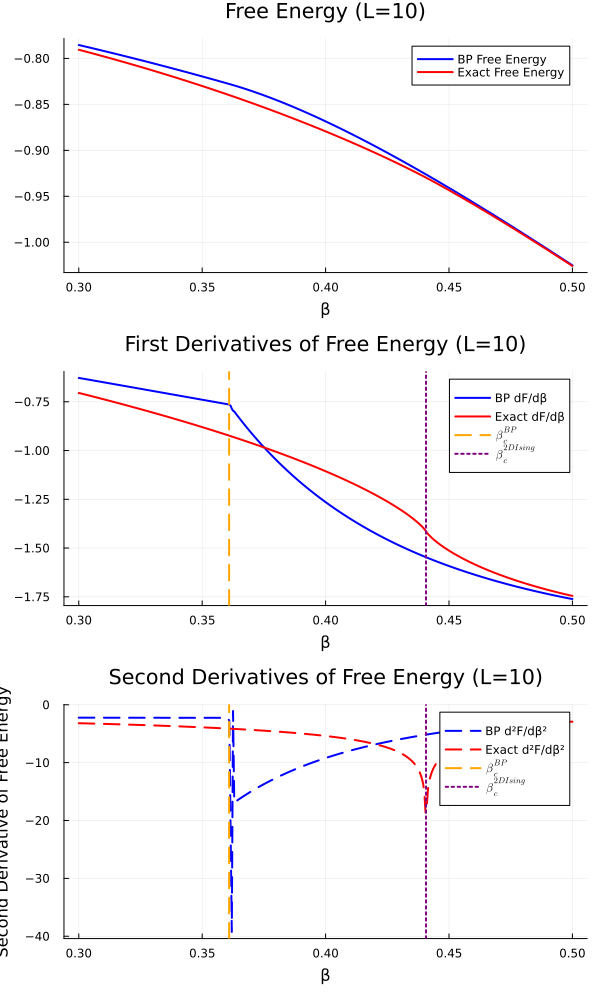

In [30]:
# Define critical points
q = 3.89
β_c_BP = log(q / (q-2))/2  # BP critical point: β_c = (1/2) ln(2)
β_c_2D_Ising = log(1 + sqrt(2))/2  # 2D Ising critical point: β_c = ln(1+√2)/2

# Create plot with free energy (no vertical lines)
p1 = plot(β_arr, free_energy_arr, 
          linewidth=2, 
          label="BP Free Energy", 
          color=:blue,
          xlabel="β", 
          ylabel="Free Energy",
          title="Free Energy (L=$L)",
          legend=:topright)

plot!(p1, β_arr, exact_free_energy, 
      linewidth=2, 
      label="Exact Free Energy", 
      color=:red)

# Create plot for first derivatives (with vertical lines)
p2 = plot(β_arr, bp_first_deriv,
          linewidth=2,
          label="BP dF/dβ",
          color=:blue,
          linestyle=:solid,
          xlabel="β",
          ylabel="First Derivative of Free Energy",
          title="First Derivatives of Free Energy (L=$L)",
          legend=:topright)

plot!(p2, β_arr, exact_first_deriv,
      linewidth=2,
      label="Exact dF/dβ",
      color=:red,
      linestyle=:solid)

# Add vertical lines to first derivative plot
vline!(p2, [β_c_BP], linestyle = :dash, color = :orange, linewidth = 2, 
       label = L"\beta_c^{BP}")
vline!(p2, [β_c_2D_Ising], linestyle = :dot, color = :purple, linewidth = 2, 
       label = L"\beta_c^{2D Ising}")

# Create plot for second derivatives (with vertical lines)
p3 = plot(β_arr, bp_second_deriv,
          linewidth=2,
          label="BP d²F/dβ²",
          color=:blue,
          linestyle=:dash,
          xlabel="β",
          ylabel="Second Derivative of Free Energy",
          title="Second Derivatives of Free Energy (L=$L)",
          legend=:topright)

plot!(p3, β_arr, exact_second_deriv,
      linewidth=2,
      label="Exact d²F/dβ²",
      color=:red,
      linestyle=:dash)

# Add vertical lines to second derivative plot
vline!(p3, [β_c_BP], linestyle = :dash, color = :orange, linewidth = 2, 
       label = L"\beta_c^{BP}")
vline!(p3, [β_c_2D_Ising], linestyle = :dot, color = :purple, linewidth = 2, 
       label = L"\beta_c^{2D Ising}")

# Create combined plot layout (3 separate plots)
combined_plot = plot(p1, p2, p3, layout=(3,1), size=(600, 1000))

# Display the combined plot
display(combined_plot)

4
8
12
8
12


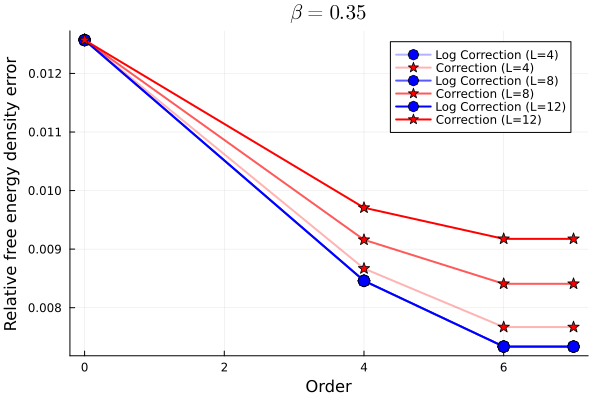

In [ ]:
##noisy init
L_arr = [4, 8, 12]
β = 0.35
orders = [0, 4, 6, 7]
colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plt = plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Relative free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)

    exact_fe = Ising2D.free_energy(β)
    y1 = (log_loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    y2 = (loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

# Add vertical lines for critical points
β_c_BP = log(2)/2  # BP critical point: β_c = (1/2) ln(2)
β_c_2D_Ising = log(1 + sqrt(2))/2  # 2D Ising critical point: β_c = ln(1+√2)/2

vline!([β_c_BP], linestyle = :dash, color = :orange, linewidth = 2, 
       label = L"\beta_c^{BP} = \frac{1}{2}\ln(2)")
vline!([β_c_2D_Ising], linestyle = :dot, color = :purple, linewidth = 2, 
       label = L"\beta_c^{2D Ising} = \frac{\ln(1+\sqrt{2})}{2}")

# annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))
plt

4
8
12
8
12


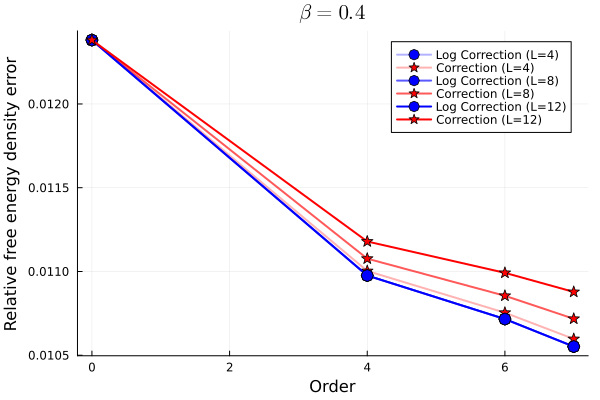

In [33]:
##noisy init
L_arr = [4, 8, 12]
β = 0.4
orders = [0, 4, 6, 7]
colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plt = plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Relative free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)

    exact_fe = Ising2D.free_energy(β)
    y1 = (log_loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    y2 = (loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

# annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))
plt

4
8
12
8
12


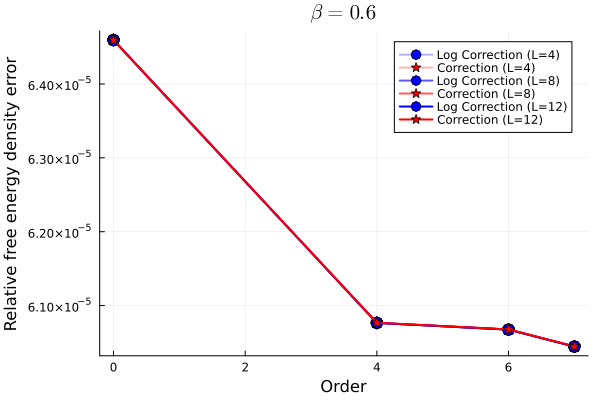

In [34]:
##noisy init
L_arr = [4, 8, 12]
β = 0.6
orders = [0, 4, 6, 7]
colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plt = plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Relative free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)

    exact_fe = Ising2D.free_energy(β)
    y1 = (log_loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    y2 = (loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

# annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))
plt

In [ ]:
# scan over β values
βs = range(.01, 1., length=10)

L = 10
N = 2 * L^2
h = 0.0

# array of BP fixed point free energy
bp_fixed_point_free_energy_array = []
# array of loop corrected BP free energy
loop_corrected_free_energy_array = []
log_loop_corrected_free_energy_array = []

# array of bounary evolution free energy
boundary_evolution_free_energy_array = []
# exact free energy
exact_free_energy_array = [Ising2D.free_energy(β) for β in βs]

# time for BP fixed point
bp_fixed_point_time = []

log_loop_correction_time = []
# time for loop corrections
loop_correction_time = []
# time for boundary evolution
boundary_evolution_time = []

for β in βs
    println("Current β: ", β)
    time_start = time()
    bp_fixed_point_free_energy_array = vcat(bp_fixed_point_free_energy_array, BP_fixed_point_free_energy(L,β))
    bp_fixed_point_time = vcat(bp_fixed_point_time, time() - time_start)

    time_start = time()
    loop_corrected_free_energy_array = vcat(loop_corrected_free_energy_array, loop_corrected_free_energy(L,β)[end])
    loop_correction_time = vcat(loop_correction_time, time() - time_start)

    time_start = time()
    log_loop_corrected_free_energy_array = vcat(log_loop_corrected_free_energy_array, log_loop_corrected_free_energy(L,β)[end])
    log_loop_correction_time = vcat(loop_correction_time, time() - time_start)


    time_start = time()
    peps = generate_ising_peps(L, L, β, h)
    partition_function = contract_peps_no_phys(peps; cutoff=1E-8, maxdim=1024)
    boundary_evolution_free_energy_array = vcat(boundary_evolution_free_energy_array, (-log(partition_function)/N)/2)
    boundary_evolution_time = vcat(boundary_evolution_time, time() - time_start)
end

Current β: 0.01
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.12
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.23
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complet

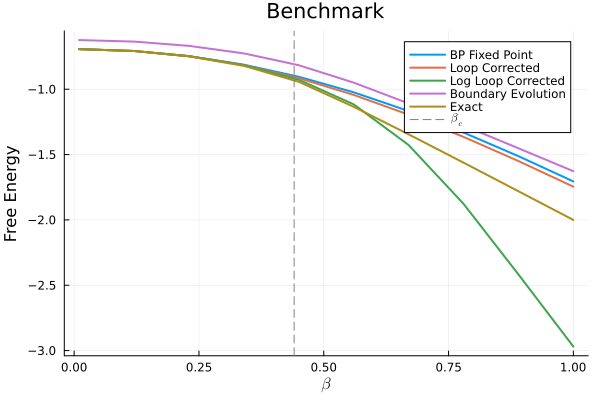

In [62]:
plot(title = "Benchmark", xlabel = L"\beta", ylabel = "Free Energy")

plot!(βs, bp_fixed_point_free_energy_array;
     label = "BP Fixed Point",
     linewidth = 2,
)

plot!(βs, loop_corrected_free_energy_array;
      label = "Loop Corrected",
      linewidth = 2,
)

plot!(βs, log_loop_corrected_free_energy_array;
      label = "Log Loop Corrected",
      linewidth = 2,
)

plot!(βs, boundary_evolution_free_energy_array;
      label = "Boundary Evolution",
      linewidth = 2,
)

plot!(βs, exact_free_energy_array;
      label = "Exact",
      linewidth = 2,
)

vline!([0.4406868], linestyle = :dash, color = :grey, label=L"\beta_c")

In [38]:
log_loop_corrected_free_energy_array

11-element Vector{Any}:
 -0.693247183894657
 -0.7076206004914029
 -0.747213344276731
 -0.8154691964753047
 -0.9156207179122269
 -1.0437490633071518
 -1.1948866177049506
 -1.3649230123161826
 -1.5498034185784806
 -1.7457500563892066
 -2.969403946560505

In [ ]:
function switch_up_down(T::ITensor)
    """
    Switch the up and down components of a two-element single index ITensor.
    
    Args:
        T: ITensor with a single index of dimension 2
        
    Returns:
        ITensor with up and down components switched
    """
    # Get the index
    ind = only(inds(T))
    
    # Check that the index has dimension 2
    if dim(ind) != 2
        error("ITensor must have a single index of dimension 2")
    end
    
    # Create a new ITensor for the result
    T_switched = ITensor(ind)
    
    # Switch the components: up (1) -> down (2), down (2) -> up (1)
    T_switched[ind => 1] = T[ind => 2]  # new up = old down
    T_switched[ind => 2] = T[ind => 1]  # new down = old up
    
    return T_switched
end

# Alternative implementation using permutation matrix
function switch_up_down_perm(T::ITensor)
    """
    Switch the up and down components using a permutation matrix approach.
    
    Args:
        T: ITensor with a single index of dimension 2
        
    Returns:
        ITensor with up and down components switched
    """
    # Get the index
    ind = only(inds(T))
    
    # Check that the index has dimension 2
    if dim(ind) != 2
        error("ITensor must have a single index of dimension 2")
    end
    
    # Create permutation matrix that swaps elements
    perm_matrix = ITensor([0 1; 1 0], ind', ind)
    
    # Apply the permutation
    return perm_matrix * T
end

# Test the function
function test_switch_up_down()
    # Create a test index
    i = Index(2, "test")
    
    # Create a test ITensor with up=1.0, down=2.0
    T = ITensor(i)
    T[i => 1] = 1.0  # up component
    T[i => 2] = 2.0  # down component
    
    println("Original ITensor:")
    println("Up component (1): ", T[i => 1])
    println("Down component (2): ", T[i => 2])
    
    # Switch up and down
    T_switched = switch_up_down(T)
    
    println("\nSwitched ITensor:")
    println("Up component (1): ", T_switched[i => 1])
    println("Down component (2): ", T_switched[i => 2])
    
    # Test permutation version
    T_switched_perm = switch_up_down_perm(T)
    
    println("\nSwitched ITensor (permutation method):")
    println("Up component (1): ", T_switched_perm[i => 1])
    println("Down component (2): ", T_switched_perm[i => 2])
    
    return T_switched, T_switched_perm
end

# Run the test
test_switch_up_down()